In [19]:


from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

from tqdm import tqdm

In [20]:
def create_image_mask_subarray(image_directory):
    image_names = glob.glob(image_directory+"*.png")
    image_names.sort()
   
    images = [cv2.imread(img,0) for img in image_names]

    image_dataset = np.array(images)
    image_dataset = np.expand_dims(image_dataset,axis=3)
    return image_dataset


In [21]:
mask_directory = 'train_videos/000/maskedImages/'
image_directory = 'train_videos/000/rawImages/'

image_dataset=create_image_mask_subarray(image_directory)

mask_dataset=create_image_mask_subarray(mask_directory)

In [22]:
from PIL import Image
path = 'train_annotations'

dir_list = os.listdir(path)
for inddir in tqdm(dir_list):
        if(int(inddir[0:3])>0 and int(inddir[0:3])<2):
            mask_directory = 'train_videos/'+inddir[0:3]+"/maskedImages/"
            image_directory = 'train_videos/'+inddir[0:3]+"/rawImages/"

            image_dataset=np.concatenate((image_dataset, create_image_mask_subarray(image_directory)))
            
            mask_dataset=np.concatenate((mask_dataset, create_image_mask_subarray(mask_directory)))





100%|██████████| 737/737 [00:00<00:00, 996.80it/s]


In [23]:

print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))


Image data shape is:  (272, 512, 512, 1)
Mask data shape is:  (272, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211

In [24]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

        
#### Testing generator, generates augmented images


Image data shape is:  (272, 512, 512, 1)
Mask data shape is:  (272, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211

In [25]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


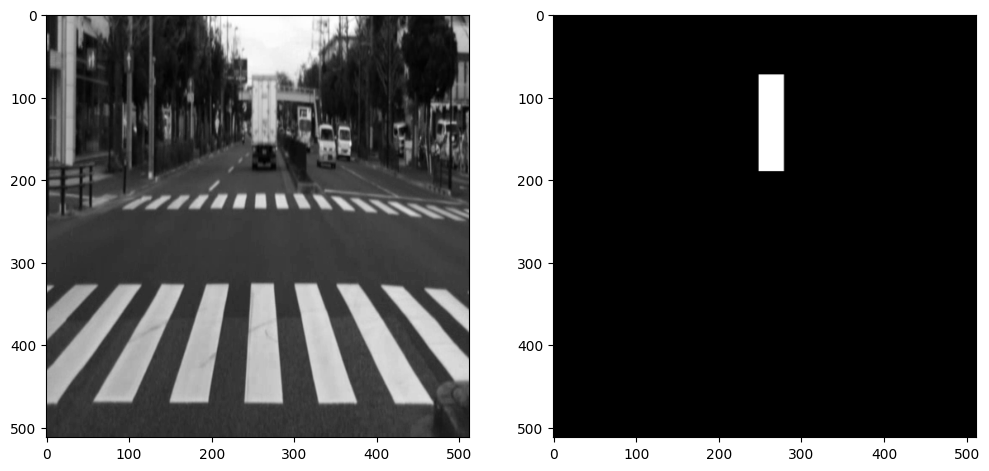

In [27]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()


In [28]:
# import the necessary packages
from Dual_model import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch


class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16),nbClasses=1, retainDim=True,outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
        super().__init__()
		# initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
        map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
		# return the segmentation map
        return map


In [29]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)



In [30]:
unet = UNet().to(config.DEVICE)


In [31]:
from torch.utils.data import DataLoader
trainLoader = DataLoader((X_train,y_train), shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader((X_test,y_test), shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

In [32]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(X_train) // config.BATCH_SIZE
testSteps = len(X_test) // config.BATCH_SIZE
print("testSteps"+str(testSteps))
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

testSteps6


In [33]:
import time
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		# print(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x1, y1) in testLoader:
			# send the input to the device
			(x1, y1) = (x1.to(config.DEVICE), y1.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x1)

			loss=lossFunc(pred,y1)

			totalTestLoss += loss
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training historyß
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))


# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

[INFO] training the network...


  0%|          | 0/40 [00:01<?, ?it/s]
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 266, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


RuntimeError: Input type (double) and bias type (float) should be the same

In [166]:
model.save('25epoch_lead_vehicle_segmentation.hdf5')

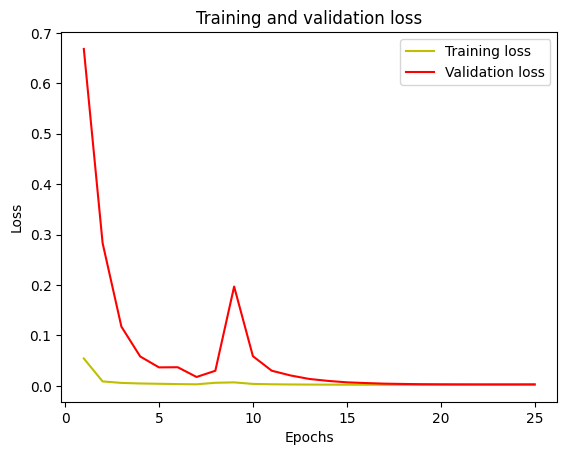

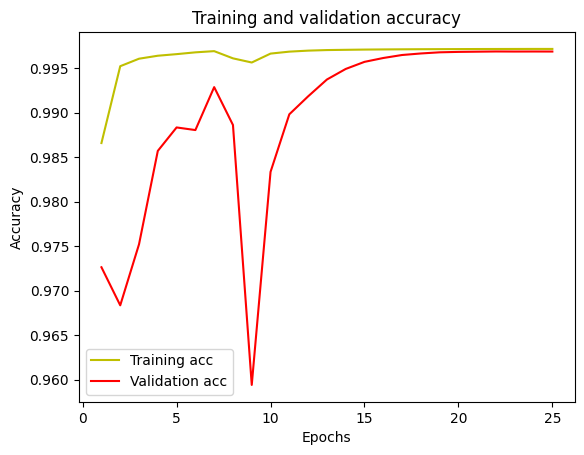

In [167]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [168]:
from keras.models import load_model
model = load_model('25epoch_lead_vehicle_segmentation.hdf5', compile=False)


In [169]:

y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 0s 206ms/step


In [170]:
from tensorflow.keras.metrics import MeanIoU

In [171]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9522604


(1, 512, 512, 1)
1/1 [==============================] - 0s 16ms/step
(512, 512)


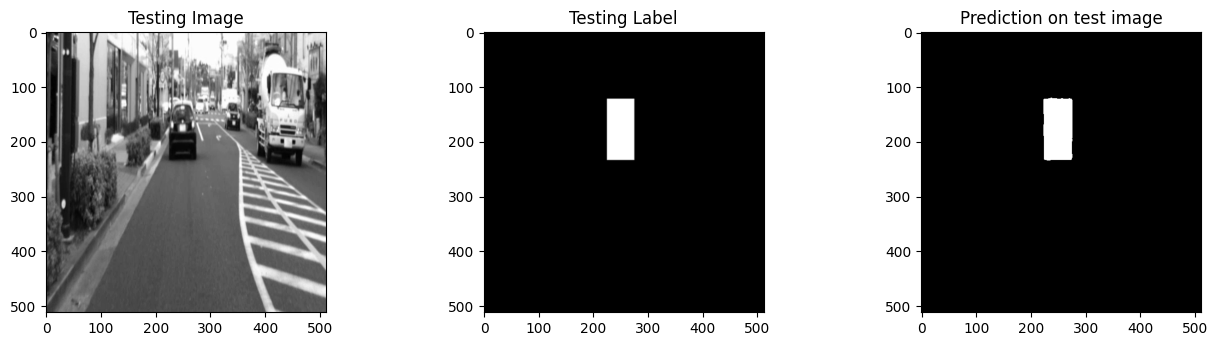

In [172]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()